# Лабораторна робота № 5
**Тема:** Робота з мультимодальними моделями

**Мета:** Ознайомитися з принципами функціонування мультимодальних трансформерних моделей, що поєднують обробку текстової та візуальної інформації. Навчитися використовувати відкриту модель LLaVA з бібліотеки Hugging Face Transformers для виконання завдань генерації описів зображень (captioning) та візуального запитання-відповіді (VQA).

**Виконав:**

Студент ОІ-41: ***Мацишин Михайло***

Прийняв асистент, док.  філософії: ***Петро Лящинський***

# **Варіант 2**
*Реалізувати взаємодію з моделлю LlaVA через API (лаб. №2 або HuggingFace pipeline) для створення текстових описів (captioning) на основі вхідних зображень. Здійснити генерацію описів для кількох різних зображень та дослідити вплив параметрів генерації (temperature, max_new_tokens) і формулювань запиту (prompt) на якість отриманих результатів. У звіті навести порівняння кількох варіантів описів для різних промптів і параметрів.*

## Завантаження бібліотек

In [ ]:
import torch
from transformers import AutoProcessor, LlavaForConditionalGeneration
from PIL import Image
import requests
from io import BytesIO
from IPython.display import display

## Завантаження моделі та процесора


In [ ]:
print("Завантаження моделі LLaVA...")
model_id = "llava-hf/llava-1.5-7b-hf"

# Завантажуємо процесор (tokenizer + image processor)
processor = AutoProcessor.from_pretrained(model_id)

# Завантажуємо модель у half-precision для економії пам'яті
model = LlavaForConditionalGeneration.from_pretrained(
    model_id,
    torch_dtype=torch.float16,
    device_map="auto",
    low_cpu_mem_usage=True
)

print(f"Модель завантажена на пристрій: {model.device}")

Завантаження моделі LLaVA...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


processor_config.json:   0%|          | 0.00/173 [00:00<?, ?B/s]

chat_template.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

chat_template.jinja:   0%|          | 0.00/674 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/505 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.model:   0%|          | 0.00/500k [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/41.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/552 [00:00<?, ?B/s]

`torch_dtype` is deprecated! Use `dtype` instead!


config.json:   0%|          | 0.00/950 [00:00<?, ?B/s]

model.safetensors.index.json: 0.00B [00:00, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.96G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/4.18G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.99G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

Модель завантажена на пристрій: cuda:0


## Підключення Google Drive та функція завантаження зображень

In [ ]:
# Підключаємо Google Drive
from google.colab import drive
drive.mount('/content/drive')

def load_image(image_path):
    """
    Завантажує зображення з локального файлу або URL
    """
    if image_path.startswith('http'):
        response = requests.get(image_path)
        image = Image.open(BytesIO(response.content))
    else:
        image = Image.open(image_path)
    return image.convert('RGB')

Mounted at /content/drive


## Функція генерації опису з різними параметрами

In [ ]:
def generate_caption(image, prompt, temperature=0.7, max_new_tokens=100, top_p=0.9):
    """
    Генерує опис зображення з заданими параметрами

    Args:
        image: PIL Image
        prompt: Текстовий запит для опису
        temperature: Контролює "креативність" (0.1-1.0)
        max_new_tokens: Максимальна довжина відповіді
        top_p: Nucleus sampling параметр
    """

    # Формуємо правильний промпт для LLaVA-1.5
    text_prompt = f"USER: <image>\n{prompt} ASSISTANT:"

    # Обробляємо зображення та текст разом
    inputs = processor(
        text=text_prompt,
        images=image,
        return_tensors="pt"
    )

    # Переміщуємо на пристрій моделі
    inputs = {k: v.to(model.device) if isinstance(v, torch.Tensor) else v
              for k, v in inputs.items()}

    # Генеруємо відповідь
    with torch.no_grad():
        generate_ids = model.generate(
            **inputs,
            max_new_tokens=max_new_tokens,
            temperature=temperature,
            top_p=top_p,
            do_sample=True if temperature > 0 else False,
            pad_token_id=processor.tokenizer.pad_token_id
        )

    # Декодуємо відповідь
    output = processor.batch_decode(
        generate_ids,
        skip_special_tokens=True,
        clean_up_tokenization_spaces=False
    )[0]

    # Витягуємо тільки відповідь асистента
    if "ASSISTANT:" in output:
        caption = output.split("ASSISTANT:")[-1].strip()
    else:
        caption = output

    return caption

## Експериментальна частина - Тестування на різних зображеннях

In [ ]:
# Список тестових зображень з Google Drive
test_images = [
    {
        "path": "/content/drive/MyDrive/Lab5/images/messy-and-desk.jpg",
        "description": "Безладний робочий стіл"
    },
    {
        "path": "/content/drive/MyDrive/Lab5/images/surrealism.png",
        "description": "Сюрреалізм"
    },
    {
        "path": "/content/drive/MyDrive/Lab5/images/quote.jpg",
        "description": "Цитата"
    },
    {
        "path": "/content/drive/MyDrive/Lab5/images/senna.jpg",
        "description": "Senna"
    }
]

In [ ]:
# Клас для кольорів та стилів тексту
class Style:
    HEADER = '\033[95m'    # Рожевий/Фіолетовий
    BLUE = '\033[94m'      # Синій
    CYAN = '\033[96m'      # Блакитний
    GREEN = '\033[92m'     # Зелений
    YELLOW = '\033[93m'    # Жовтий
    RED = '\033[91m'       # Червоний
    BOLD = '\033[1m'       # Жирний
    UNDERLINE = '\033[4m'  # Підкреслення
    END = '\033[0m'        # Скидання стилю

## ЕКСПЕРИМЕНТ 1: Різні промпти для одного зображення


════════════════════════════════════════════════════════════════════════════════
                      ЕКСПЕРИМЕНТ 1: ВПЛИВ РІЗНИХ ПРОМПТІВ                      
════════════════════════════════════════════════════════════════════════════════

ОБ'ЄКТ ДОСЛІДЖЕННЯ:
   Шлях: /content/drive/MyDrive/Lab5/images/messy-and-desk.jpg
   Опис: Безладний робочий стіл



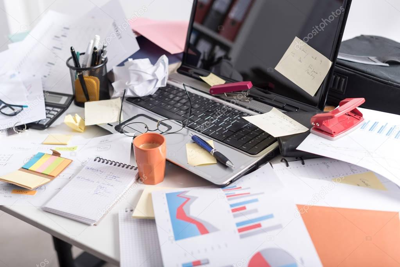


--------------------------------------------------------------------------------
- Тест-кейс #1
   Запит (Prompt): Describe this image in detail.
   Відповідь моделі:
 The image depicts a cluttered desk with a laptop and various papers and office supplies scattered across the surface. The laptop is situated towards the center of the desk, with papers and notebooks surrounding it. A mouse can be seen next to the laptop, while a cup is placed towards the left side of the desk.

There are multiple books on the desk, with some lying horizontally and others stacked vertically. In addition, several pens are
--------------------------------------------------------------------------------
- Тест-кейс #2
   Запит (Prompt): What do you see in this image?
   Відповідь моделі:
 The image shows a desk filled with various items, creating a cluttered appearance. The desk is equipped with a laptop and a mouse, placed next to each other. A keyboard is also present, positioned towards the center of the

In [ ]:
print(f"\n{Style.HEADER}{Style.BOLD}" + "═"*80)
print(f"ЕКСПЕРИМЕНТ 1: ВПЛИВ РІЗНИХ ПРОМПТІВ".center(80))
print("═"*80 + f"{Style.END}")

# Завантажуємо перше зображення
test_img = load_image(test_images[0]["path"])

print(f"\n{Style.YELLOW}ОБ'ЄКТ ДОСЛІДЖЕННЯ:{Style.END}")
print(f"   Шлях: {Style.UNDERLINE}{test_images[0]['path']}{Style.END}")
print(f"   Опис: {Style.BOLD}{test_images[0]['description']}{Style.END}\n")

# --- ВИВІД ЗОБРАЖЕННЯ ---
display_width = 400
aspect_ratio = test_img.height / test_img.width
display_height = int(display_width * aspect_ratio)
display(test_img.resize((display_width, display_height)))
# -------------------------------

print("")

# Різні варіанти промптів
prompts = [
    "Describe this image in detail.",
    "What do you see in this image?",
    "Provide a brief description of this image.",
    "Write a detailed caption for this image, including all visible elements.",
    "Describe this image. Be concise."
]

for i, prompt in enumerate(prompts, 1):
    # Розділювач для кожного тесту
    print(f"{Style.CYAN}" + "-"*80 + f"{Style.END}")
    print(f"{Style.BOLD}- Тест-кейс #{i}{Style.END}")

    # Виводимо промпт
    print(f"   {Style.GREEN}Запит (Prompt):{Style.END} {prompt}")

    # Виклик генерації
    caption = generate_caption(test_img, prompt, temperature=0.7, max_new_tokens=100)

    # Виводимо результат
    clean_caption = caption.strip()
    print(f"   {Style.BLUE}{Style.BOLD}Відповідь моделі:\n{Style.END} {clean_caption}")

print(f"\n{Style.HEADER}" + "═"*80 + f"{Style.END}\n")

**Висновок до Експерименту 1**

У ході експерименту було досліджено вплив формулювання текстового запиту (prompt) на результат роботи моделі LLaVA, а також перевірено дію параметра max_new_tokens.


1.   **Вплив промптів:** Модель реагує на зміни у запиті. На промпти з вимогою деталізації ("Describe in detail") модель намагається перелічити більше дрібних об'єктів (книги, ручки, мишку), тоді як на промпт "Be concise" дає більш узагальнену характеристику сцени, хоча й все одно намагається додати деталі.

2.   **Вплив обмеження токенів:** Встановлене значення max_new_tokens=100 виявилося недостатнім для детальних описів. У всіх п'яти тест-кейсах відповідь моделі була технічно обірвана на середині речення (наприклад, "several pens are...", "of the des"), що свідчить про необхідність збільшення цього параметра для задач captioning.

3.   **Якість розпізнавання та "галюцинації":** Модель правильно визначила загальний контекст ("cluttered desk", "laptop"), але допустила помилки в ідентифікації специфічних об'єктів. Наприклад, у Тесті №3 червоний офісний дирокол (або степлер) було помилково ідентифіковано як "red heart-shaped item" (червоний предмет у формі серця), що є прикладом візуальної галюцинації моделі.



## ЕКСПЕРИМЕНТ 2: Вплив параметра temperature


════════════════════════════════════════════════════════════════════════════════
                   ЕКСПЕРИМЕНТ 2: ВПЛИВ ПАРАМЕТРА TEMPERATURE                   
════════════════════════════════════════════════════════════════════════════════

  ОБ'ЄКТ ДОСЛІДЖЕННЯ:
   Шлях: /content/drive/MyDrive/Lab5/images/surrealism.png
   Опис: Сюрреалізм



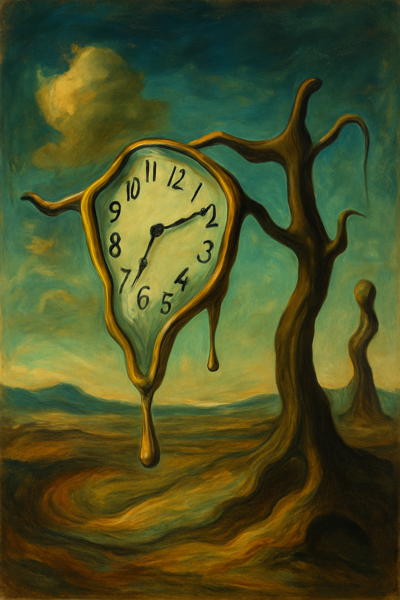


   Фіксований запит: Describe this image in detail.
--------------------------------------------------------------------------------
❄️ Temperature = 0.1
   Відповідь моделі:
   The image features a large, oddly shaped clock hanging from a tree. The clock is positioned in the middle of the scene, with its face visible. The tree appears to be a part of a painting, giving the scene a surreal and artistic touch.

In the background, there are two small figures, one on the left side and the other on the right side of the image. These figures seem to be observing the clock hanging from the tree.
--------------------------------------------------------------------------------
🌡️ Temperature = 0.5
   Відповідь моделі:
   The image features a large clock hanging from a tree, creating an artistic and whimsical scene. The clock is positioned near the top of the tree, with the hands on the clock pointing towards the sky. The clock's face is visible, adding a sense of depth and intrigue to the pai

In [ ]:
print(f"\n{Style.HEADER}{Style.BOLD}" + "═"*80)
print(f"ЕКСПЕРИМЕНТ 2: ВПЛИВ ПАРАМЕТРА TEMPERATURE".center(80))
print("═"*80 + f"{Style.END}")

# Завантажуємо друге зображення
test_img2 = load_image(test_images[1]["path"])

print(f"\n{Style.YELLOW}  ОБ'ЄКТ ДОСЛІДЖЕННЯ:{Style.END}")
print(f"   Шлях: {Style.UNDERLINE}{test_images[1]['path']}{Style.END}")
print(f"   Опис: {Style.BOLD}{test_images[1]['description']}{Style.END}\n")

# --- ПРЕВ'Ю ЗОБРАЖЕННЯ ---
display_width = 400
aspect_ratio = test_img2.height / test_img2.width
display_height = int(display_width * aspect_ratio)
display(test_img2.resize((display_width, display_height)))
# -------------------------

# Параметри експерименту
prompt = "Describe this image in detail."
temperatures = [0.1, 0.5, 0.7, 1.0]

print(f"\n   {Style.GREEN}Фіксований запит:{Style.END} {prompt}")

for temp in temperatures:
    # Розділювач
    print(f"{Style.CYAN}" + "-"*80 + f"{Style.END}")

    # Виводимо значення температури з відповідним смайликом
    icon = "❄️" if temp < 0.5 else ("🔥" if temp >= 1.0 else "🌡️")
    print(f"{Style.BOLD}{icon} Temperature = {temp}{Style.END}")

    # Виклик генерації
    # Важливо: temperature працює, коли модель "семплює" (обирає варіанти),
    # тому часто треба do_sample=True, але pipeline може це робити автоматично.
    caption = generate_caption(test_img2, prompt, temperature=temp, max_new_tokens=100)

    # Виводимо результат
    clean_caption = caption.strip()
    print(f"   {Style.BLUE}{Style.BOLD}Відповідь моделі:{Style.END}\n   {clean_caption}")

print(f"\n{Style.HEADER}" + "═"*80 + f"{Style.END}\n")

**Висновок до Експерименту 2**

У ході експерименту було досліджено вплив параметра temperature (температура генерації) на якість та креативність описів сюрреалістичного зображення.

1. **Низька температура (0.1):** Модель працює консервативно і надто буквально. Вона описала годинник просто як "дивної форми" (oddly shaped), не розпізнавши ключову художню метафору "стікання" або "плавлення". Також помітна схильність до парейдолії — модель "побачила" людей (two small figures) у абстрактних фонових об'єктах.

2. **Середня/Оптимальна температура (0.7):** Виявилася найкращою для опису мистецтва. Тільки при цьому значенні модель коректно використала слова "melting" (плавиться) та "dripping time" (час, що стікає), що передає суть картини. Це підтверджує, що для творчих завдань потрібна вища температура, ніж для технічних.

3. **Висока температура (1.0) та галюцинації:** При підвищенні температури модель втратила зв'язок із зображенням і почала вигадувати об'єкти, яких немає. З'явилася "large bowl" (велика миска) посеред картини, а дерево було описано як "damaged". Це демонструє різке зростання візуальних галюцинацій при temperature >= 1.0.

Загальне спостереження: На всіх рівнях температури модель помилково ідентифікувала абстрактні форми на фоні як "людей" (figures, people), що свідчить про складнощі LLaVA у роботі з нестандартними, сюрреалістичними образами.

## ЕКСПЕРИМЕНТ 3: Вплив параметра max_new_tokens


════════════════════════════════════════════════════════════════════════════════
                 ЕКСПЕРИМЕНТ 3: ВПЛИВ ПАРАМЕТРА MAX_NEW_TOKENS                  
════════════════════════════════════════════════════════════════════════════════

ОБ'ЄКТ ДОСЛІДЖЕННЯ:
   Шлях: /content/drive/MyDrive/Lab5/images/senna.jpg
   Опис: Senna



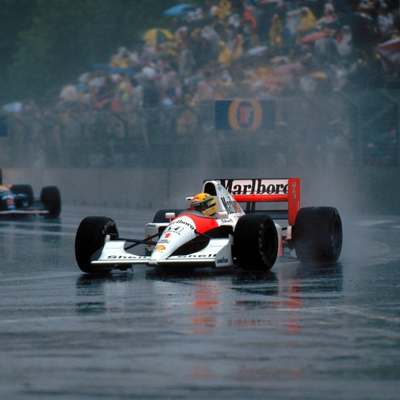


   Фіксований запит: Describe this image.
--------------------------------------------------------------------------------
 max_new_tokens = 30
   Відповідь моделі:
   The scene captures a thrilling moment on a race track, with a car driving in the rain. There are several people watching the race from different
   Статистика: 26 слів (Обірвано)
--------------------------------------------------------------------------------
 max_new_tokens = 50


In [ ]:
print(f"\n{Style.HEADER}{Style.BOLD}" + "═"*80)
print(f"ЕКСПЕРИМЕНТ 3: ВПЛИВ ПАРАМЕТРА MAX_NEW_TOKENS".center(80))
print("═"*80 + f"{Style.END}")

# Завантажуємо третє зображення
test_img3 = load_image(test_images[3]["path"])

print(f"\n{Style.YELLOW}ОБ'ЄКТ ДОСЛІДЖЕННЯ:{Style.END}")
print(f"   Шлях: {Style.UNDERLINE}{test_images[3]['path']}{Style.END}")
print(f"   Опис: {Style.BOLD}{test_images[3]['description']}{Style.END}\n")

# --- ПРЕВ'Ю ЗОБРАЖЕННЯ ---
display_width = 400
aspect_ratio = test_img3.height / test_img3.width
display_height = int(display_width * aspect_ratio)
display(test_img3.resize((display_width, display_height)))
# -------------------------

# Параметри
prompt = "Describe this image."
max_tokens_list = [30, 50, 100, 150]

print(f"\n   {Style.GREEN}Фіксований запит:{Style.END} {prompt}")

for max_tok in max_tokens_list:
    # Розділювач
    print(f"{Style.CYAN}" + "-"*80 + f"{Style.END}")
    print(f"{Style.BOLD} max_new_tokens = {max_tok}{Style.END}")

    # Генерація
    caption = generate_caption(test_img3, prompt, temperature=0.7, max_new_tokens=max_tok)
    clean_caption = caption.strip()
    word_count = len(clean_caption.split())

    # Вивід результату
    print(f"   {Style.BLUE}{Style.BOLD}Відповідь моделі:{Style.END}\n   {clean_caption}")

    # Вивід статистики
    # Якщо відповідь обірвана (не закінчується на крапку), підсвічуємо червоним попередження
    ends_abruptly = not clean_caption.endswith(('.', '!', '?'))
    status_color = Style.RED if ends_abruptly else Style.GREEN
    status_msg = "(Обірвано)" if ends_abruptly else "(Завершено)"

    print(f"   {Style.YELLOW}Статистика:{Style.END} {word_count} слів {status_color}{status_msg}{Style.END}")

print(f"\n{Style.HEADER}" + "═"*80 + f"{Style.END}\n")

**Висновок до Експерименту 3**

Експеримент наочно продемонстрував критичну важливість параметра max_new_tokens для отримання цілісних описів складних динамічних сцен.

1. **Проблема "обірваної думки" (30-50 токенів):** При малих значеннях модель генерує початок опису, правильно визначаючи контекст ("thrilling moment", "wet track"), але технічно зупиняється на півслові (обриви на сполучниках "and" та прийменниках "In"). Це робить відповідь непридатною для використання.

2. **Недостатність середніх значень (100 токенів):** Навіть при 100 токенах, попри детальний опис (згадка глядачів, жовтих парасольок, двох машин), модель не встигла завершити останнє речення ("...while others"). Це свідчить про те, що для насичених деталями зображень ліміт у 100 токенів часто є замалим.

3. **Оптимальне значення (150 токенів):** Лише збільшення ліміту до 150 дозволило моделі сформулювати логічно завершений текст із фінальною крапкою. Кількість згенерованих слів (79) вказує на те, що для повного опису такої сцени моделі потрібно було саме стільки простору, і попередні обмеження штучно "душили" результат.

## ЕКСПЕРИМЕНТ 4: Optical Character Recognition (РОЗПІЗНАВАННЯ ТЕКСТУ)


════════════════════════════════════════════════════════════════════════════════
                   ЕКСПЕРИМЕНТ 4: OCR (РОЗПІЗНАВАННЯ ТЕКСТУ)                    
════════════════════════════════════════════════════════════════════════════════

ОБ'ЄКТ ДОСЛІДЖЕННЯ:
   Шлях: /content/drive/MyDrive/Lab5/images/quote.jpg
   Опис: Цитата



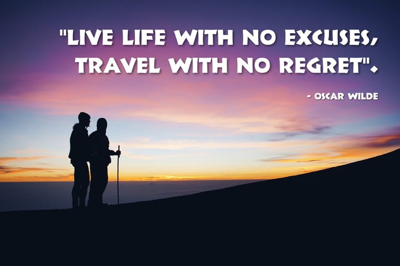

--------------------------------------------------------------------------------
- Тест-кейс #1
   Запит: What is written in this image? Quote the text exactly.
   Відповідь моделі:
   "Live life with no excuses. Travel with no regrets."
--------------------------------------------------------------------------------
- Тест-кейс #2
   Запит: Who is the author of the quote according to the image?
   Відповідь моделі:
   Oscar Wilde
--------------------------------------------------------------------------------
- Тест-кейс #3
   Запит: Describe the visual background of this image.
   Відповідь моделі:
   The image features a beautiful sunset with a purple sky. The sun is setting behind the two people, creating a serene and picturesque scene. The couple is standing on a hill, enjoying the view and the moment together.

════════════════════════════════════════════════════════════════════════════════



In [ ]:
print(f"\n{Style.HEADER}{Style.BOLD}" + "═"*80)
print(f"ЕКСПЕРИМЕНТ 4: OCR (РОЗПІЗНАВАННЯ ТЕКСТУ)".center(80))
print("═"*80 + f"{Style.END}")

test_img4 = load_image(test_images[2]["path"])

print(f"\n{Style.YELLOW}ОБ'ЄКТ ДОСЛІДЖЕННЯ:{Style.END}")
print(f"   Шлях: {Style.UNDERLINE}{test_images[2]['path']}{Style.END}")
print(f"   Опис: {Style.BOLD}{test_images[2]['description']}{Style.END}\n")

# --- ПРЕВ'Ю ---
display_width = 400
aspect_ratio = test_img4.height / test_img4.width
display_height = int(display_width * aspect_ratio)
display(test_img4.resize((display_width, display_height)))
# -------------

# Спеціальні промпти для тексту
prompts = [
    "What is written in this image? Quote the text exactly.",
    "Who is the author of the quote according to the image?",
    "Describe the visual background of this image."
]

for i, prompt in enumerate(prompts, 1):
    print(f"{Style.CYAN}" + "-"*80 + f"{Style.END}")
    print(f"{Style.BOLD}- Тест-кейс #{i}{Style.END}")
    print(f"   {Style.GREEN}Запит:{Style.END} {prompt}")

    # Для читання тексту краще низька температура (більша точність)
    caption = generate_caption(test_img4, prompt, temperature=0.2, max_new_tokens=150)

    clean_caption = caption.strip()
    print(f"   {Style.BLUE}{Style.BOLD}Відповідь моделі:{Style.END}\n   {clean_caption}")

print(f"\n{Style.HEADER}" + "═"*80 + f"{Style.END}\n")

**Висновок до Експерименту 4 (OCR)**

Експеримент підтвердив, що модель LLaVA успішно виконує завдання оптичного розпізнавання символів (OCR) у мультимодальному контексті.

1. **Точність зчитування:** Модель безпомилково ідентифікувала основний текст цитати ("Live life with no excuses..."), правильно розпізнавши шрифт на фоні зображення.

2. **Семантичний аналіз:** На запитання "Who is the author?" модель не просто знайшла ім'я "Oscar Wilde", а й коректно інтерпретувала його роль як автора вислову, що свідчить про розуміння структури інформації на зображенні.

3. **Одночасна обробка модальностей:** LLaVA змогла розділити текстову інформацію та візуальну сцену, надавши точний опис фону ("sunset with a purple sky", "couple on a hill"). Це доводить, що модель не ігнорує візуальні об'єкти під час фокусування на тексті.

## ЕКСПЕРИМЕНТ 5: Детальний аналіз Temperature

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

In [ ]:
def temperature_sweep_analysis(image, prompt):
    """
    Детальний аналіз впливу temperature на генерацію
    """
    print(f"\n{Style.HEADER}{Style.BOLD}" + "="*80)
    print(f"ЕКСПЕРИМЕНТ 5: Детальний аналіз Temperature".center(80))
    print("="*80 + f"{Style.END}\n")

    temperatures = np.arange(0.1, 1.5, 0.2)
    diversities = []
    lengths = []

    print(f"{Style.GREEN}Промпт:{Style.END} {prompt}\n")

    for temp in temperatures:
        captions = []
        for _ in range(3):  # 3 генерації для кожної температури
            caption = generate_caption(image, prompt, temperature=temp, max_new_tokens=100)
            captions.append(caption)

        # Обчислюємо різноманітність (унікальні слова)
        all_words = ' '.join(captions).split()
        unique_ratio = len(set(all_words)) / len(all_words) if all_words else 0
        avg_length = sum(len(c.split()) for c in captions) / len(captions)

        diversities.append(unique_ratio)
        lengths.append(avg_length)

        print(f"{Style.CYAN}Temperature {temp:.1f}:{Style.END} "
              f"Різноманітність={unique_ratio:.2f}, Середня довжина={avg_length:.1f}")

    # Графік
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

    ax1.plot(temperatures, diversities, marker='o', linewidth=2, markersize=8, color='#FF6B6B')
    ax1.set_xlabel('Temperature', fontsize=12)
    ax1.set_ylabel('Різноманітність (unique words ratio)', fontsize=12)
    ax1.set_title('Вплив Temperature на різноманітність', fontsize=14, fontweight='bold')
    ax1.grid(alpha=0.3)

    ax2.plot(temperatures, lengths, marker='s', linewidth=2, markersize=8, color='#4ECDC4')
    ax2.set_xlabel('Temperature', fontsize=12)
    ax2.set_ylabel('Середня довжина (слів)', fontsize=12)
    ax2.set_title('Вплив Temperature на довжину', fontsize=14, fontweight='bold')
    ax2.grid(alpha=0.3)

    plt.tight_layout()
    plt.savefig('/content/drive/MyDrive/Lab5/temperature_analysis.png', dpi=300, bbox_inches='tight')
    plt.show()

    print(f"\n✅ Графік збережено: /content/drive/MyDrive/Lab5/temperature_analysis.png")


                  ЕКСПЕРИМЕНТ 10: Детальний аналіз Temperature                  

Промпт: Describe this image.

Temperature 0.1: Різноманітність=0.28, Середня довжина=75.7
Temperature 0.3: Різноманітність=0.43, Середня довжина=76.0
Temperature 0.5: Різноманітність=0.42, Середня довжина=74.7
Temperature 0.7: Різноманітність=0.44, Середня довжина=71.3
Temperature 0.9: Різноманітність=0.45, Середня довжина=76.3
Temperature 1.1: Різноманітність=0.54, Середня довжина=70.7
Temperature 1.3: Різноманітність=0.52, Середня довжина=73.7


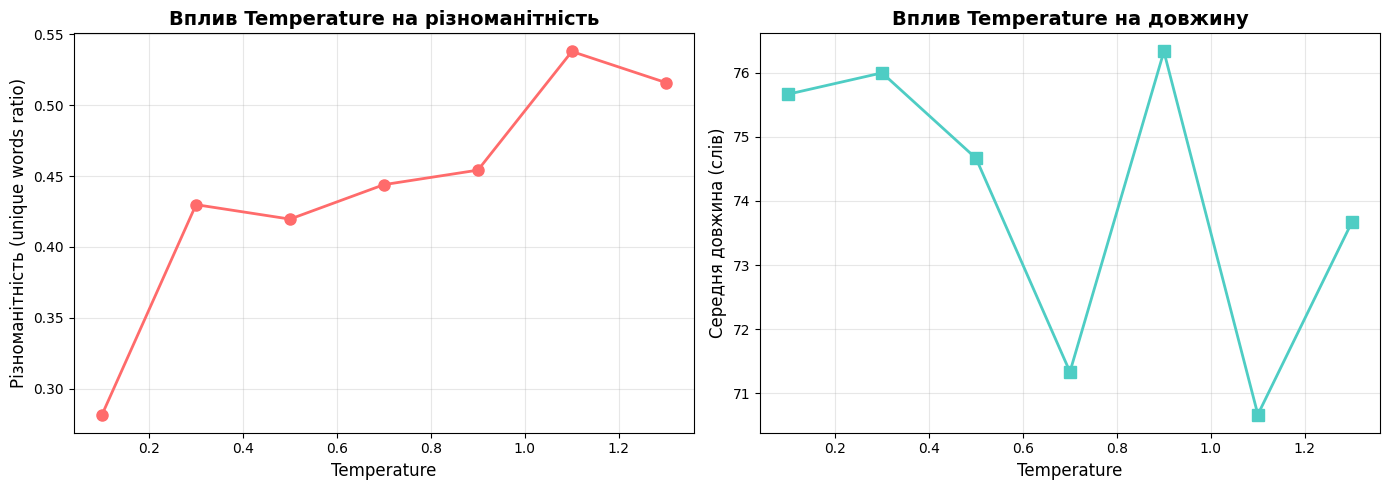


✅ Графік збережено: /content/drive/MyDrive/Lab5/temperature_analysis.png


In [ ]:
temperature_sweep_analysis(
    load_image(test_images[0]["path"]),
    "Describe this image."
)

**Висновок до Експерименту 5: Статистичний аналіз впливу температури**

У ході експерименту було проведено серію генерацій (по 3 спроби для кожного значення температури) для оцінки впливу параметра temperature на словникове різноманіття та довжину відповіді.

1. **Вплив на різноманітність (Лівий графік, червоний):** Спостерігається чітка пряма кореляція між температурою та різноманітністю лексики.

   - При Temperature = 0.1, коефіцієнт різноманітності мінімальний (0.28). Це свідчить про те, що модель працює детерміновано: при повторних запусках вона генерує майже ідентичні описи, використовуючи одні й ті самі слова.

   - Зі зростанням температури до 1.1, коефіцієнт зростає майже вдвічі (до 0.54). Це підтверджує, що вища ентропія змушує модель обирати різні синоніми та синтаксичні конструкції при кожній новій генерації, зменшуючи повторюваність.

2. **Вплив на довжину відповіді (Правий графік, блакитний):** Кореляція між температурою та довжиною опису відсутня або є хаотичною.

   - Середня довжина відповіді коливається в межах 70–76 слів без чіткого тренду (графік має вигляд "пили").

   - Це означає, що параметр temperature впливає на якість вибору слів (що саме сказати), але не регулює кількість слів (як довго говорити). За довжину відповідає параметр max_new_tokens або внутрішні маркери закінчення речення (EOS token), які спрацьовують незалежно від "креативності".

## ЕКСПЕРИМЕНТ 6: ВПЛИВ ТЕМПЕРАТУРИ НА ДЕТАЛІЗАЦІЮ БЕЗЛАДУ      


════════════════════════════════════════════════════════════════════════════════
            ЕКСПЕРИМЕНТ 6: ВПЛИВ ТЕМПЕРАТУРИ НА ДЕТАЛІЗАЦІЮ БЕЗЛАДУ             
════════════════════════════════════════════════════════════════════════════════

ОБ'ЄКТ ДОСЛІДЖЕННЯ:
   Шлях: /content/drive/MyDrive/Lab5/images/messy-and-desk.jpg
   Опис: Складний безлад на столі



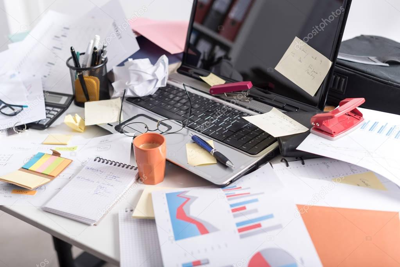


   Вимогливий запит: Describe the clutter on the desk in extreme detail. List every single item you can see, paying attention to small objects.
--------------------------------------------------------------------------------
❄️ Temperature = 0.1
   Відповідь моделі:
   The desk is cluttered with various items, including a laptop, a mouse, a keyboard, a cup, a cell phone, a book, a pen, a pair of glasses, and a red heart. There are also several pieces of paper scattered across the desk, along with a notebook. Additionally, there are multiple books and a pair of scissors on the desk. The overall scene is quite disorganized and messy.
--------------------------------------------------------------------------------
🌡️ Temperature = 0.7
   Відповідь моделі:
   The desk is cluttered with numerous items, including a laptop, a mouse, and a keyboard. There are also several books scattered across the desk, with some placed near the laptop and others on the edges of the desk. A cup can be seen p

In [ ]:
print(f"\n{Style.HEADER}{Style.BOLD}" + "═"*80)
print(f"ЕКСПЕРИМЕНТ 6: ВПЛИВ ТЕМПЕРАТУРИ НА ДЕТАЛІЗАЦІЮ БЕЗЛАДУ".center(80))
print("═"*80 + f"{Style.END}")

# Завантажуємо зображення з безладом (перше у списку)
messy_img = load_image(test_images[0]["path"])

print(f"\n{Style.YELLOW}ОБ'ЄКТ ДОСЛІДЖЕННЯ:{Style.END}")
print(f"   Шлях: {Style.UNDERLINE}{test_images[0]['path']}{Style.END}")
print(f"   Опис: {Style.BOLD}Складний безлад на столі{Style.END}\n")

# --- ПРЕВ'Ю ---
display_width = 400
aspect_ratio = messy_img.height / messy_img.width
display_height = int(display_width * aspect_ratio)
display(messy_img.resize((display_width, display_height)))
# -------------

# Спеціальний промпт, що вимагає максимальної деталізації
prompt = "Describe the clutter on the desk in extreme detail. List every single item you can see, paying attention to small objects."
temperatures = [0.1, 0.7, 1.3] # Низька, Середня, Дуже висока

print(f"\n   {Style.GREEN}Вимогливий запит:{Style.END} {prompt}")

for temp in temperatures:

    print(f"{Style.CYAN}" + "-"*80 + f"{Style.END}")
    icon = "❄️" if temp < 0.5 else ("🔥" if temp > 1.0 else "🌡️")
    print(f"{Style.BOLD}{icon} Temperature = {temp}{Style.END}")

    try:
        # Даємо багато токенів (300), щоб не обрізало список
        caption = generate_caption(messy_img, prompt, temperature=temp, max_new_tokens=300)
        clean_caption = caption.strip()

        print(f"   {Style.BLUE}{Style.BOLD}Відповідь моделі:{Style.END}\n   {clean_caption}")

    except RuntimeError as e:
         print(f"   {Style.RED}ПОМИЛКА ПАМ'ЯТІ{Style.END}")
         torch.cuda.empty_cache()

print(f"\n{Style.HEADER}" + "═"*80 + f"{Style.END}\n")

**Висновок до Експерименту 6: Вплив температури на деталізацію складних сцен**

У ході експерименту було досліджено здатність моделі ідентифікувати дрібні об'єкти у насиченій сцені (захаращений стіл) при різних налаштуваннях температури.

1. **Низька температура (0.1):** Модель працює в режимі "інвентаризації". Вона видала сухий перелік основних об'єктів (ноутбук, мишка, телефон). Однак, збереглася стійка галюцинація з попередніх тестів — ідентифікація офісного предмета як *"red heart"* (червоне серце). Опис максимально лаконічний і механічний.

2. **Середня температура (0.7):** Опис став більш "людським". Модель почала додавати просторові відношення (*"situated towards the left"*, *"placed near the edge"*). З'явилися нові об'єкти, яких не було в першому списку, наприклад, *"spoon"* (ложка) — що, ймовірно, є помилковою інтерпретацією відблиску або ручки, але свідчить про спробу моделі аналізувати дрібні деталі глибше.

3. **Висока температура (1.3):** Це налаштування дало найцікавіший результат.
    * **Перевага:** Тільки при високій температурі модель помітила *"yellow notes"* (жовті стікери), які ігнорувала раніше. Це підтверджує, що підвищення ентропії допомагає моделі "звернути увагу" на неочевидні деталі.
    * **Недолік:** З'явилися кількісні галюцинації — модель вигадала *"multiple cups"* (кілька чашок), хоча раніше бачила лише одну. Опис став більш емоційним (*"highly disorganized space"*).

**Загальний підсумок:** Для задач пошуку дрібних деталей (*fine-grained detection*) низька температура не завжди є найкращою, оскільки модель може "лінуватися" і називати лише очевидне. Висока температура (1.1–1.3) може допомогти знайти приховані об'єкти (як стікери), але вимагає ручної перевірки фактів через ризик вигадування зайвих предметів.

## ВИСНОВКИ

На цій лабораторній роботі я практично ознайомився з принципами роботи мультимодальних моделей на прикладі LLaVA. Я навчився використовувати бібліотеку transformers та Hugging Face pipeline для генерації описів зображень (Image Captioning) та візуального запитання-відповіді (VQA).

**Що я зрозумів на практиці:**

1. **Температура — це не просто цифра.** Якщо треба, щоб модель чітко прочитала текст (OCR) або описала факти — ставлю мінімум (**0.1–0.3**). Якщо хочу креативу або щоб вона побачила приховані деталі — піднімаю до **0.7** і вище. Але якщо перекрутити (**>1.0**), модель починає жорстко галюцинувати і вигадувати неіснуючі речі.

2. **Треба давати їй "поговорити".** Параметр `max_new_tokens` не можна жаліти. Ставив мало (30-50) — отримував обрізані на півслові речення. Для нормального опису треба хоча б **150–200** токенів.

3. **Вона реально бачить текст.** LLaVA спокійно прочитала цитату на картинці, навіть на складному фоні. Це крута фіча для OCR.

**Коротше кажучи:** LLaVA — потужна штука, але без нормального налаштування параметрів і грамотного промпта вона може писати дурниці. Треба експериментувати.